In [314]:
### doc data 
import scipy.io
from scipy.stats import norm
mat = scipy.io.loadmat('E:/data/2Dparticle.mat')
lm=mat['lm']
xodo=mat['XODO']
xtrue=mat['XTRUE']
vg=mat['VG']
z=mat['Z']


In [299]:
#tao particle
def particle(v,delta_v,g,delta_g,toa_do,so_mau):##toa do array 1 chiu
    v=np.random.normal(v,delta_v,so_mau)# so particle
    g=np.random.normal(g,delta_g,so_mau)# so particle bang cach them noise
    # bb 
   
    toado=np.zeros((3,so_mau))
    toado[2]=toa_do[2]+g
    toado[0] =toa_do[0]+v*0.025*np.cos(toado[2])## hoanh do
    toado[1]=toa_do[1]+v*0.025*np.sin(toado[2])## tung do
     ## goc steering
    return toado
##tinh khoang cach cua cac particle ts lnmark tung ung, neu gia tri trong vector la nan, tinh theo tung z
def khoangcach(toado_lm,toado_p,id_lm):##toa do lm la array 10x2 chieu, toa do particle all particle(3x so mau),id_lm(z3)(1x5)
        N=toado_p.shape[1] ## so particle
        toado_paticle=toado_p[0:2].T
        distan=np.zeros((N,5))
        goc=np.zeros((N,5))
        for j in range(5):
            if(np.isnan(id_lm[j])):
                break
                
            else:
                    for i in range(N):
            
                            temp= toado_lm[id_lm[j].astype(int)-1]-toado_paticle[i]
                           
                            distan[i][j]=np.sqrt(np.sum(temp*temp))
                            
                            mz=complex(temp[0],temp[1])
                            
                            goc[i][j]=np.angle(mz)-toado_p[2][i]
                            
                            
                            
        return distan,goc ## array so_maux5


In [300]:

def weight(z,distan,goc,so_mau,k):### tinnh cho 1 bo particle,z=3x5x625,m=1000x5,n=1000x5
    weight=np.ones((so_mau,))
    
    ###tinnh xac xuat khoang cachs
    r=z[0].T
    alpha=z[1].T
    
    for i in range(so_mau):
        
        count=0
        temp=0
        
        for j in range(5):
                    if(np.isnan(r[k][j])):## neu z is NaN thi z, goc, alpha giong nhau
                                if count==0:
                            
                                        break
                                else:
                                    
                                        weight[i]=temp
                                        break
                  
                    else:   
                                count=count+1
                                ##distan la mean. std=0.2
                                total_dis=np.arange(distan[i][j]-1,distan[i][j]+1,0.0001) 
                                sum_dis=sum(norm.pdf(total_dis,distan[i][j],0.2))# khaong cach
                                eyes_dis=np.arange(r[k][j]-0.01,r[k][j]+0.01,0.0001)
                                temp=temp+sum(norm.pdf(eyes_dis,distan[i][j],0.2))/sum_dis
                               
                                ## goc la mean, std=2 degree
                                total_goc=np.arange(goc[i][j]-np.pi/18,goc[i][j]+np.pi/18,0.0001)
                                sum_goc=sum(norm.pdf(total_goc,goc[i][j],np.pi/90))
                             
                                eyes_goc=np.arange(alpha[k][j]-0.01,alpha[k][j]+0.01,0.0001)
                                temp=temp+sum(norm.pdf(eyes_goc,goc[i][j],np.pi/90))/sum_goc
                                

                
    return weight    ### cho 1 particle      
                
                
        
         
    

[-0.0007212   0.01331884 -0.10130555]


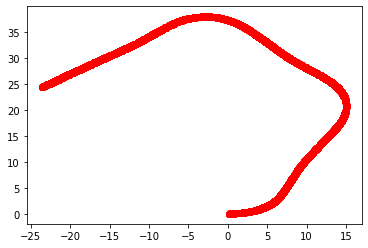

In [301]:
### tinh toa do chua them noise
import numpy as np
N=625

x_n_noise=np.zeros((3,N))
for i  in range(N):
    x_n_noise[0][i]=xodo[0][i]-np.cos(xodo[2][i])*vg[0][i]*0.025  ## hoanh do
    x_n_noise[1][i]=xodo[1][i]-np.sin(xodo[2][i])*vg[0][i]*0.025## tung do
    x_n_noise[2][i]=xodo[2][i]-vg[1][i] # goc lech so voi phuong ngang
print(x_n_noise.T[0])
## tinh particle
so_mau=1000
quy_dao_max=[]
quy_dao_min=[]
quy_dao_tb=[]
for M in range(N):
                        toa_do_particle=particle(vg[0][M],0.5,vg[1][M],np.pi/60,x_n_noise.T[M],so_mau)## cho 1 timestep
                       
                       
                        ## tính khoảng cách
                        m,n=khoangcach(lm.T,toa_do_particle,z[2].T[M])
                        
                        
                        ##mean la measurement tien doan vs vi tri particle, tu dok tinnh weight
                        w=weight(z,m,n,so_mau,M)
                       
                        w=w/sum(w)

                        ####resampling, theo sx , 
                        id_re=[]
                        ar=np.arange(0,so_mau)
                        for i in range(so_mau):
                            id_re.append(np.random.choice(ar,1,p=w))
                        
                        ss=w[id_re]## trong so sau khi rut ra
                        id_max_true=id_re[np.argmax(ss)] ## tra ve id max
                        id_min_true=id_re[np.argmin(ss)] ## min
                        quy_dao_max.append(toa_do_particle.T[id_max_true])
                        quy_dao_min.append(toa_do_particle.T[id_min_true])
                        tbinh=toa_do_particle.T[id_re]
                        quy_dao_tb.append(sum(tbinh)/so_mau)

(3, 625)


Text(0.5, 1.0, 'quy dao xodo')

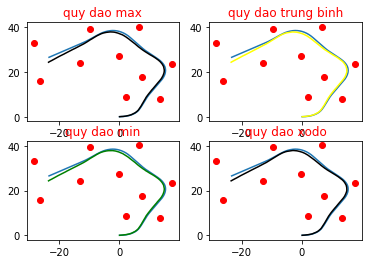

In [318]:
quy_dao_m1=np.array(quy_dao_max)

qd_max=quy_dao_m1.reshape((625,3)).T

qd_m2=np.array(quy_dao_min)

qd_min=qd_m2.reshape((625,3)).T

qd_tb=np.array(quy_dao_tb)

qd_tbc=qd_tb.reshape((625,3)).T
print(qd_max.shape)
plt.subplot(221)
plt.plot(lm[0],lm[1],'ro')
plt.plot(xtrue[0],xtrue[1],label="xtrue")
plt.plot(qd_max[0],qd_max[1],color='black')
plt.title("quy dao max",color='red')

plt.subplot(222)
plt.plot(lm[0],lm[1],'ro')
plt.plot(xtrue[0],xtrue[1],label="xtrue")
plt.plot(qd_tbc[0],qd_tbc[1],color='yellow')
plt.title("quy dao trung binh",color='red')

plt.subplot(223)
plt.plot(lm[0],lm[1],'ro')
plt.plot(xtrue[0],xtrue[1],label="xtrue")
plt.plot(qd_min[0],qd_min[1],color='green')
plt.title("quy dao min",color='red')

plt.subplot(224)
plt.plot(lm[0],lm[1],'ro')
plt.plot(xtrue[0],xtrue[1],label="xtrue")
plt.plot(xodo[0],xodo[1],color='black')
plt.title("quy dao xodo",color="red")

In [337]:
adg=np.random.randint(1 ,5,(4,4,4,4))

ads=adg.reshape(-1,16*16)
print(ads.shape)

(1, 256)
